In [1]:
import numpy as np
import cv2
import math

import numpy as np
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img

import matplotlib.pyplot as plt
import random
import os
from config import Config
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization


RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

In [11]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import cv2

In [12]:
config = Config()


In [13]:
IMAGE_SIZE=(config.image_width, config.image_height)
IMAGE_CHANNELS= config.number_of_channels

def get_generated_data_from_file():
    filenames = os.listdir("../Data/")

    categories = []
    for filename in filenames:
        category = filename.split('_')[0]
        if category == 'Bar':
            categories.append(1)
        else:
            categories.append(0)

    df = pd.DataFrame({
        'filename': filenames,
        'category': categories
    })
    
    df = df.sample(frac = 1)
    
    df["category"] = df["category"].replace({0: 'Pie', 1: 'Bar'})

    train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
    train_df = train_df.reset_index(drop=True)
    validate_df = validate_df.reset_index(drop=True)

    return train_df, validate_df
    


    


def get_CatDog_model():

    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(config.image_width, config.image_height, config.number_of_channels)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    model.summary()

    return model




#barcharts, piecharts = generate_data()


train_data, validation_data  = get_generated_data_from_file()
model = get_CatDog_model()

2022-12-06 16:28:31.647153: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-06 16:28:31.647332: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 298, 298, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 149, 149, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 batch_normalization_1 (Ba

In [16]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]


total_train = train_data.shape[0]
total_validate = validation_data.shape[0]
print(total_train)
print(total_validate)
batch_size=15

train_datagen = ImageDataGenerator(
    rotation_range=0,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    "../Data/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)



validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_data,
    "../Data/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)



8000
2001
Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


/Users/mahsa/miniconda3/envs/CV/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


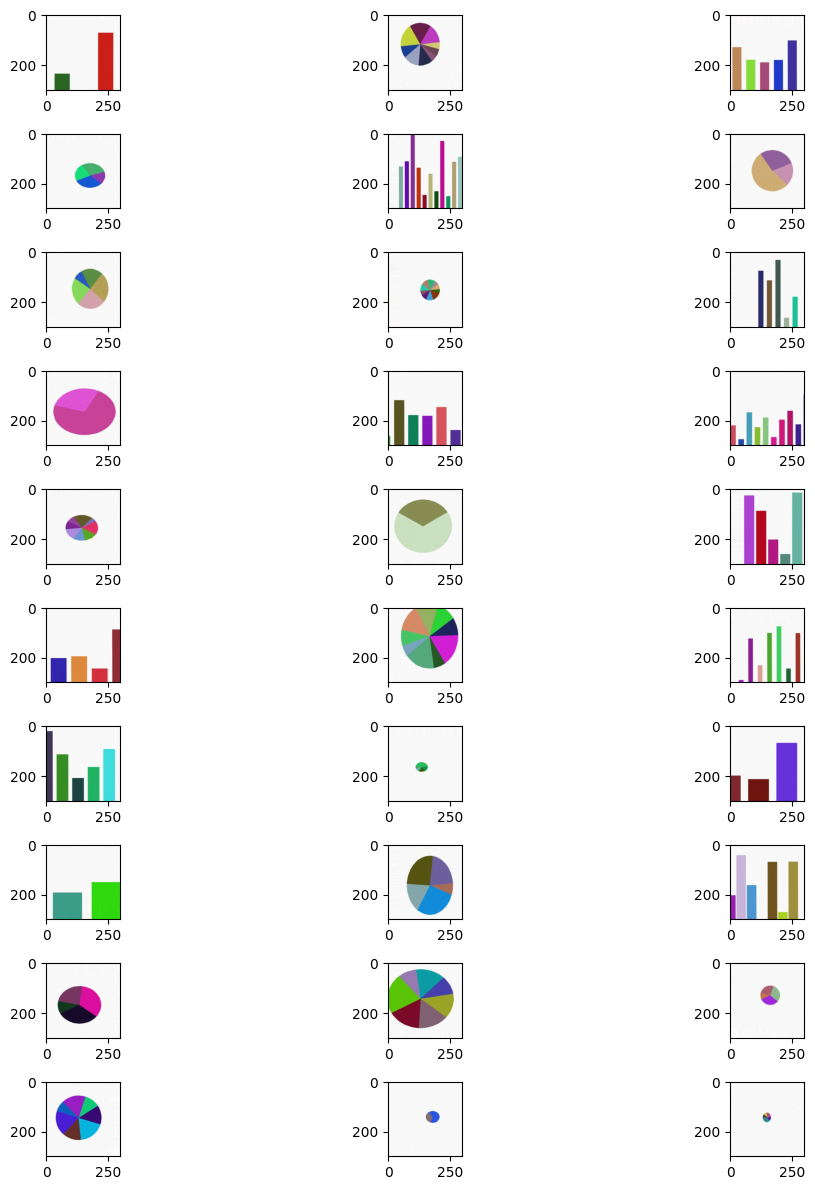

In [23]:
plt.figure(figsize=(12, 12))
for i in range(0, 30):
    plt.subplot(10, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [24]:
epochs= 50
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)





fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Epoch 1/50


/var/folders/l5/19b5ln3x2wg1ks3mh2q5ygn80000gp/T/ipykernel_4203/2482446747.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2022-12-06 16:38:13.988277: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-06 16:38:14.384847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


533/533 [==============================] - ETA: 0s - loss: 0.0760 - accuracy: 0.9837

2022-12-06 16:40:32.567456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


533/533 [==============================] - 145s 268ms/step - loss: 0.0760 - accuracy: 0.9837 - val_loss: 8.6854e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/50
533/533 [==============================] - 143s 268ms/step - loss: 0.0261 - accuracy: 0.9944 - val_loss: 0.5584 - val_accuracy: 0.5779 - lr: 0.0010
Epoch 3/50
533/533 [==============================] - 155s 291ms/step - loss: 0.0153 - accuracy: 0.9965 - val_loss: 0.6248 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 4/50
533/533 [==============================] - 156s 292ms/step - loss: 0.0078 - accuracy: 0.9984 - val_loss: 0.4266 - val_accuracy: 0.8461 - lr: 0.0010
Epoch 5/50
533/533 [==============================] - 157s 295ms/step - loss: 0.0091 - accuracy: 0.9980 - val_loss: 3.4514e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/50
533/533 [==============================] - 165s 309ms/step - loss: 0.0092 - accuracy: 0.9984 - val_loss: 0.0233 - val_accuracy: 0.9880 - lr: 0.0010
Epoch 7/50
533/533 [=============================

KeyboardInterrupt: 

In [4]:
import os
os.path.abspath('')

'/Users/mahsa/Documents/PhDlife/Courses/1st_Semester/ML/ML_Final/PieBarChartClassification'